In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import hdbscan



# расписание 915 на Новочерёмушкинской улице
a915={'05': ['41'],
      '06': ['00', '19', '38', '52'],
      '07': ['07','25','40','54'],
      '08': ['08','22','39','56'],
      '09': ['19','42'],
      '10': ['06','30','54'],
      '11': ['18','42'],
      '12': ['06','30','54'],
      '13': ['18','37','55'],
      '14': ['14','32','50'],
      '15': ['09','28','47'],
      '16': ['06','25','43'],
      '17': ['02','22','39','56'],
      '18': ['12','28','44'],
      '19': ['00','16','31','47'],
      '20': ['03','26','49'],
      '21': ['11','31','54'],
      '22': ['14','34','54'],
      '23': ['14','34','54'],
      '24': ['14','34','54']}

Режимы движения (DBSCAN + постобработка):
Кластер 0: 6:00 – 8:56, 6 рейсов, интервал 17–19 мин, средний: 18.2 мин
Кластер 2: 9:19 – 13:18, 11 рейсов, интервал 23–24 мин, средний: 23.8 мин
Кластер 3: 13:37 – 20:03, 23 рейсов, интервал 15–20 мин, средний: 17.6 мин
Кластер 4: 20:26 – 21:54, 4 рейсов, интервал 22–23 мин, средний: 22.8 мин


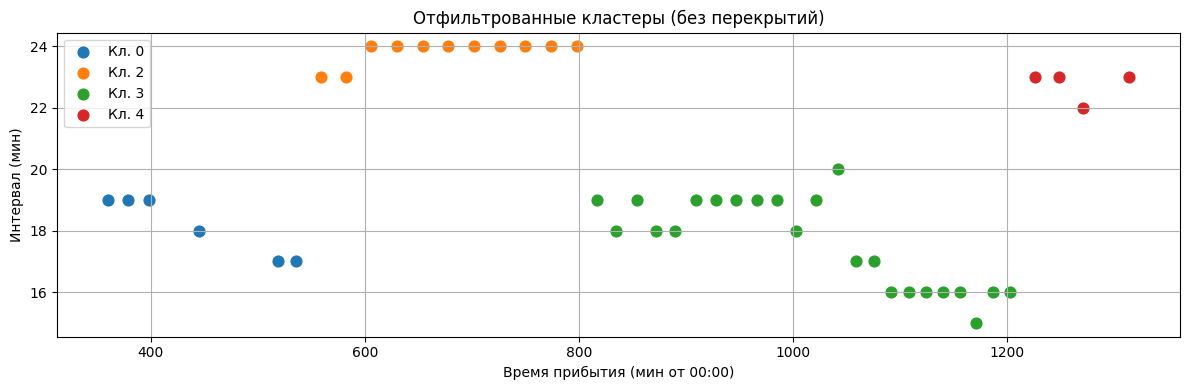

In [ ]:
# Преобразование во временные точки
arrival_times = sorted([
    int(hour) * 60 + int(minute)
    for hour, minutes in a915.items()
    for minute in minutes
])

# Интервалы
intervals = np.diff(arrival_times)
X = np.array([[t, i] for t, i in zip(arrival_times[1:], intervals)])

# Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Кластеризация
clustering = DBSCAN(eps=0.6, min_samples=3).fit(X_scaled)
labels = clustering.labels_

# Группировка
raw_clusters = defaultdict(list)
for label, (time, interval) in zip(labels, X):
    if label != -1:
        raw_clusters[label].append((time, interval))

# Подготовка к постобработке
cluster_info = []
for label, points in raw_clusters.items():
    times = sorted(p[0] for p in points)
    ivs = [p[1] for p in points]
    cluster_info.append({
        "label": label,
        "start": min(times),
        "end": max(times),
        "times": times,
        "intervals": ivs,
        "avg_interval": np.mean(ivs)
    })

# Сортировка по времени начала
cluster_info.sort(key=lambda c: c["start"])

# Постобработка: удаление вложенных кластеров
final_clusters = []
last_end = -1
for c in cluster_info:
    if c["start"] > last_end:
        final_clusters.append(c)
        last_end = c["end"]

# Вывод
print("Режимы движения (DBSCAN + постобработка):")
for c in final_clusters:
    s = str(timedelta(minutes=int(c["start"])))[:-3]
    e = str(timedelta(minutes=int(c["end"])))[:-3]
    print(f"Кластер {c['label']}: {s} – {e}, {len(c['times'])} рейсов, "
          f"интервал {min(c['intervals'])}–{max(c['intervals'])} мин, "
          f"средний: {c['avg_interval']:.1f} мин")

# Только точки из финальных кластеров
plt.figure(figsize=(12, 4))
for i, c in enumerate(final_clusters):
    plt.scatter(c["times"], c["intervals"], label=f"Кл. {c['label']}", s=60)

plt.xlabel("Время прибытия (мин от 00:00)")
plt.ylabel("Интервал (мин)")
plt.title("Отфильтрованные кластеры (без перекрытий)")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

рисерчи

Режимы движения (HDBSCAN):
Кластер 0: 12:54 – 1 day, 0:34, 38 рейсов, интервалы 15–24 мин, средний: 18.9 мин
Кластер 1: 6:00 – 10:30, 16 рейсов, интервалы 14–24 мин, средний: 18.0 мин
Кластер 2: 10:54 – 12:30, 5 рейсов, интервалы 24–24 мин, средний: 24.0 мин


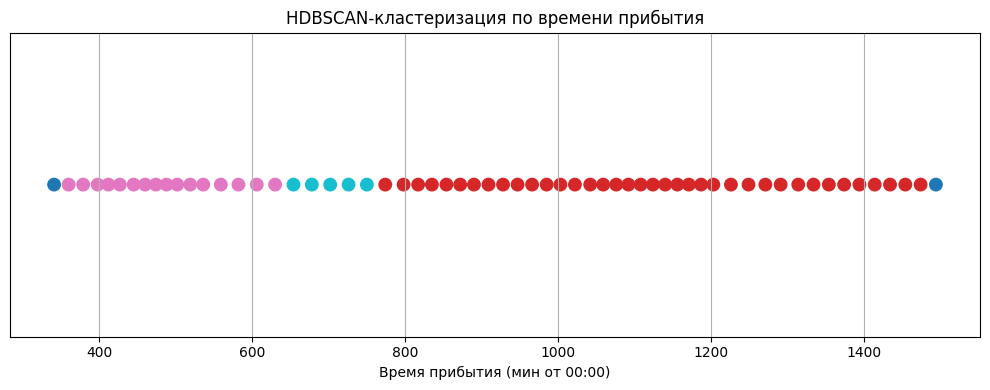

In [ ]:
# Шаг 1: преобразуем в минуты от начала суток
arrival_times = []
for hour, minutes in a915.items():
    h = int(hour)
    for m in minutes:
        #t = (h if h < 24 else 0) * 60 + int(m)
        t= h * 60 + int(m)
        arrival_times.append(t)

arrival_times = sorted(arrival_times)
X = np.array(arrival_times).reshape(-1, 1)

# Кластеризация через HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
labels = clusterer.fit_predict(X)

# Группировка результатов
clusters = defaultdict(list)
for label, time in zip(labels, arrival_times):
    if label != -1:
        clusters[label].append(time)

# Вывод
print("Режимы движения (HDBSCAN):")
for label, times in sorted(clusters.items()):
    times.sort()
    intervals = np.diff(times)
    start = str(timedelta(minutes=times[0]))[:-3]
    end = str(timedelta(minutes=times[-1]))[:-3]
    print(f"Кластер {label}: {start} – {end}, {len(times)} рейсов, "
          f"интервалы {min(intervals)}–{max(intervals)} мин, "
          f"средний: {np.mean(intervals):.1f} мин")

# Визуализация
plt.figure(figsize=(10, 4))
plt.scatter(X, [1] * len(X), c=labels, cmap='tab10', s=80)
plt.yticks([])
plt.xlabel("Время прибытия (мин от 00:00)")
plt.title("HDBSCAN-кластеризация по времени прибытия")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Шаг 1: преобразуем в минуты от начала суток
arrival_times = []
for hour, minutes in a915.items():
    h = int(hour)
    for m in minutes:
        #t = (h if h < 24 else 0) * 60 + int(m)
        t= h * 60 + int(m)
        arrival_times.append(t)

arrival_times = sorted(arrival_times)
X_time = np.array(arrival_times).reshape(-1, 1)

# Шаг 2: масштабируем и кластеризуем только по времени
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_time)

clustering = DBSCAN(eps=15, min_samples=3).fit(X_scaled)
labels = clustering.labels_

# Шаг 3: группируем по кластерам
clusters = defaultdict(list)
for label, time in zip(labels, arrival_times):
    if label != -1:
        clusters[label].append(time)

# Шаг 4: вывод
print("Режимы движения по времени:")
for label, times in sorted(clusters.items()):
    times = sorted(times)
    intervals = np.diff(times)
    start = str(timedelta(minutes=times[0]))[:-3]
    end = str(timedelta(minutes=times[-1]))[:-3]
    print(f"Кластер {label}: {start} – {end}, {len(times)} рейсов, "
          f"интервал {min(intervals)}–{max(intervals)} мин, средний: {np.mean(intervals):.1f} мин")

# Шаг 5: визуализация
plt.figure(figsize=(10, 4))
plt.scatter(X_time, [1]*len(X_time), c=labels, cmap='tab10', s=80)
plt.yticks([])
plt.xlabel("Время прибытия (мин от 00:00)")
plt.title("Кластеризация только по времени прибытия")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
times=[]
for h, ms in a915.items():
    for m in ms:
        time=h+':'+m+':00'
        times.append(time)

def get_seconds(time_str):
    # split in hh, mm, ss
    hh, mm, ss = time_str.split(':')
    return int(hh) * 3600 + int(mm) * 60 + int(ss)

seconds=[get_seconds(t) for t in times]
minutes=[get_seconds(t)//60 for t in times]

timedeltas=[0]
for i in range(1, len(minutes)):
    td=minutes[i]-minutes[i-1]
    timedeltas.append(td)

arrival_threshold=-3
departure_threshold=5

lower=list(zip([m+arrival_threshold for m in minutes][1:], [td+arrival_threshold for td in timedeltas][1:]))
upper=list(zip([m+departure_threshold for m in minutes][1:], [td+departure_threshold for td in timedeltas][1:]))

left=[lower[0], upper[0]]
right=[lower[-1], upper[-1]]

coords=[*left, *lower, *right[::-1], *upper[::-1]]

polygon=shapely.geometry.Polygon(coords)
#print(polygon)
cuts=[shapely.geometry.LineString(((m, 0), (m, 60))) for m in range(360, 1440+2*60, 60)]
polygons=[]
cut_id=[]
ctr=0
cut_polygon=polygon
for cut in cuts:
    #print(cut)
    #print(cut, end=' ')
    try:
        #print(1)
        cut_polygon=shapely.ops.split(cut_polygon, cut)
        #print(cut_polygon.geoms[0])
        polygons.append(cut_polygon.geoms[0])
        cut_polygon=cut_polygon.geoms[1]
        ctr+=1
        cut_id.append(str(ctr))
        
    except:
        #print(2)
        break
ctr+=1
cut_id.append(str(ctr))
polygons.append(cut_polygon.geoms[0])
cut_id.append(str(ctr))
